In [42]:
import pandas as pd
import numpy as np
import category_encoders as ce
from matplotlib import pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [43]:
course_df = pd.read_csv('../data/course_prepared.csv', header=0, encoding='unicode_escape')
course_df.drop(columns='Subj', inplace=True)
course_df.head()

,Course,TF_IDF,Term,Term Yr,Class Yr,Dept Desc,Cap,Enrolled
0,CSC 111,1.999042,Fall,2019,1,Computer Science,400.0,346.0
1,CSC 115,1.693109,Fall,2019,1,Computer Science,150.0,130.0
2,CSC 115,1.693109,Summer,2019,1,Computer Science,115.0,86.0
3,CSC 225,1.727549,Fall,2019,2,Computer Science,215.0,197.0
4,CSC 225,1.727549,Summer,2019,2,Computer Science,145.0,63.0


In [44]:
X_train, X_test = train_test_split(course_df, test_size=0.2, random_state=42)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

enrollment = X_train.drop(columns='Enrolled', axis='columns')
enrollment_labels = X_train['Enrolled'].copy()

Train: 176, Test: 44


In [96]:
# Separate our attributes depending on their desired transformations
num_attribs = ['Class Yr', 'Term Yr','TF_IDF']
cat_attribs = ['Term', 'Dept Desc']
log_attribs = ['Cap']
basen_attribs = ['Course']

numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log, feature_names_out="one-to-one")),
    ('scaler', StandardScaler())
])

basen_pipeline = Pipeline([
    ('base_encoder', ce.BaseNEncoder(base=15, cols=basen_attribs))
])

preprocessing = ColumnTransformer([
    ('numeric_transformer', numeric_pipeline, num_attribs),
    ('categorical_transformer', categorical_pipeline, cat_attribs),
    ('ordinal_transformer', basen_pipeline, basen_attribs),
    ('log_transformer', log_pipeline, log_attribs),
], remainder='passthrough', verbose_feature_names_out=False)

In [46]:
enrollment_prepared = preprocessing.fit_transform(enrollment)

In [47]:
preprocessing.get_feature_names_out()

array(['Class Yr', 'Term Yr', 'TF_IDF', 'Term_Fall', 'Term_Spring',
       'Term_Summer', 'Dept Desc_Computer Science',
       'Dept Desc_Electrical & Computer Engg',
       'Dept Desc_Engineering & Computer Science', 'Course_0', 'Course_1',
       'Cap'], dtype=object)

In [110]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

regressors = [
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42, learning_rate=0.08333333, max_leaf_nodes=2, n_estimators=130),
]

evaluation_metrics = {}
for idx, regressor in enumerate(regressors):
    curr_regressor = make_pipeline(preprocessing, regressor)
    curr_regressor.fit(enrollment, enrollment_labels)

    predictions = curr_regressor.predict(enrollment)

    rmses = -cross_val_score(curr_regressor, 
                             enrollment, 
                             enrollment_labels,
                             scoring="neg_root_mean_squared_error",
                             cv=10)
    
    evaluation_metrics[str(regressors[idx])] = [np.mean(rmses), predictions, curr_regressor]

for regressor, out_tuple in evaluation_metrics.items():
    print(f"{regressor}: RMSE score = {out_tuple[0]}")

best_regressor = min(evaluation_metrics, key=evaluation_metrics.get)
print(f"\nBest regressor: {best_regressor}")

RandomForestRegressor(random_state=42): RMSE score = 22.95267012720212
GradientBoostingRegressor(learning_rate=0.08333333, max_leaf_nodes=2,
                          n_estimators=130, random_state=42): RMSE score = 22.965848342851977

Best regressor: RandomForestRegressor(random_state=42)


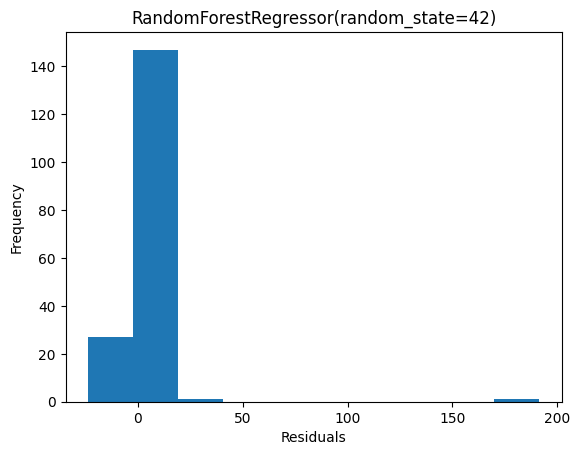

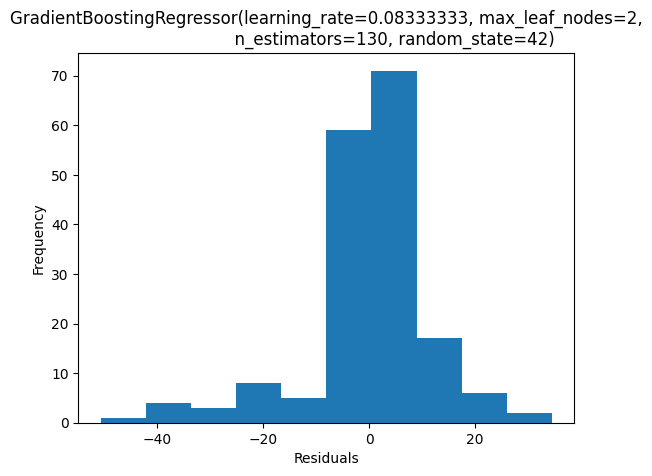

In [111]:
for regressor, out_tuple in evaluation_metrics.items():
    residuals = enrollment_labels - out_tuple[1]
    plt.hist(residuals)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(f"{regressor}")
    plt.show()

In [112]:
final_metrics = {}
for regressor, attributes in evaluation_metrics.items():
    enrolled_predictions = attributes[2].predict(X_test)
    final_mse = mean_squared_error(X_test['Enrolled'], enrolled_predictions, squared=False)

    final_metrics[regressor] = final_mse
    print(f"{regressor}: Final RMSE score = {final_mse}")

print(f"\nBest Regressor: {min(final_metrics, key=final_metrics.get)}")

RandomForestRegressor(random_state=42): Final RMSE score = 15.547727618237627
GradientBoostingRegressor(learning_rate=0.08333333, max_leaf_nodes=2,
                          n_estimators=130, random_state=42): Final RMSE score = 14.53276142553924

Best Regressor: GradientBoostingRegressor(learning_rate=0.08333333, max_leaf_nodes=2,
                          n_estimators=130, random_state=42)


In [113]:
# Perform a grid search to find the best parameters for GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
    {'gradientboostingregressor__n_estimators': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200],
     'gradientboostingregressor__max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10],
     'gradientboostingregressor__learning_rate': [0.05, 0.05555556, 0.06111111, 0.06666667, 0.07222222, 0.07777778, 0.08333333, 0.08888889, 0.09444444, 0.1]}
]

to_be_searched = list(evaluation_metrics.keys())[1]
gb_reg = evaluation_metrics[to_be_searched][2]
grid_search = RandomizedSearchCV(gb_reg, 
                                 param_grid, 
                                 cv=10,
                                 scoring='neg_root_mean_squared_error',
                                 n_iter=60,
                                 random_state=42)
grid_search.fit(enrollment, enrollment_labels)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('numeric_transformer',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Class '
                                                                                'Yr',
                                                                                'Term '
                                                                                'Yr',
                                                                                'TF_IDF']),
                                                                              ('categorical_transformer',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder())]),
                                                                               ['Term',
                                                                                'Dept '
                                                                                'Desc']),
                                                                              ('ordinal_transformer'...
                   param_distributions=[{'gradientboostingregressor__learning_rate': [0.05,
                                                                                      0.05555556,
                                                                                      0.06111111,
                                                                                      0.06666667,
                                                                                      0.07222222,
                                                                                      0.07777778,
                                                                                      0.08333333,
                                                                                      0.08888889,
                                                                                      0.09444444,
                                                                                      0.1],
                                         'gradientboostingregressor__max_leaf_nodes': [2,
                                                                                       3,
                                                                                       4,
                                                                                       5,
                                                                                       6,
                                                                                       7,
                                                                                       8,
                                                                                       9,
                                                                                       10],
                                         'gradientboostingregressor__n_estimators': [100,
                                                                                     110,
                                                                                     120,
                                                                                     130,
                                                                                     140,
                                                                                     150,
                                 

In [114]:
# Print the best parameters
print(grid_search.best_estimator_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Class Yr', 'Term Yr',
                                                   'TF_IDF']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Term', 'Dept Desc']),
                                                 ('ordinal_transformer',
                                                  Pipeline(steps=[('base_encoder',
                                                       